In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd


In [2]:
import os
import shutil
import glob
import zipfile
import cv2
import random as rd
import matplotlib.pyplot as plt


In [3]:
import time
import datetime

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

import tensorflow_datasets as tfds


In [5]:
Root_dir = "/content"
Zip_dir = "/content/drive/MyDrive/data/vegetables.zip"
Data_dir = "/content/dataset"

if os.path.exists(Data_dir):
  print("기존 directory 삭제")
  shutil.rmtree(Data_dir)

#  Data 다운로드
#  confirm=t 추가해 바이러스 검사 x
Data_Url = "https://drive.google.com/uc?export=download&id=16kGefMea0BArS3pFBbba8xpWEqXJ9twH&confirm=t"
tf.keras.utils.get_file(
    os.path.join(Root_dir,"vegetables.zip"),
    origin=Data_Url,
    extract=True,
    cache_subdir="",
    cache_dir=Root_dir)

os.rename("/content/Vegetable Images","/content/dataset")




560031432/560031432 [==============================] - 13s 0us/step


In [6]:
#각 라벨의 랜덤 이미지 1개의 주소 리턴
def get_img(dir):
  img_list = []
  label_name = []
  for i,veg_name in enumerate(os.listdir(dir)):
    veg_dir = dir+"/"+veg_name
    vegetables = glob.glob(veg_dir+"/**")
    veg_len = len(vegetables)
    label_count[veg_name] = veg_len
    img_index = rd.randrange(veg_len)
    img_dir = vegetables[img_index]
    img_list.append(img_dir)
    label_name.append(veg_name)

  return label_name,img_list

#이미지 주소 plt로 출력
def show_img(label_name,img_list):
  images = []
  plt.figure(figsize=(18,12))
  for i in range(len(img_list)):
    img = cv2.imread(img_list[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.subplot(3,5,i+1)
    plt.title(label_name[i])
    plt.axis(False)
    plt.imshow(img)
    images.append(img)
  plt.show()
  return images

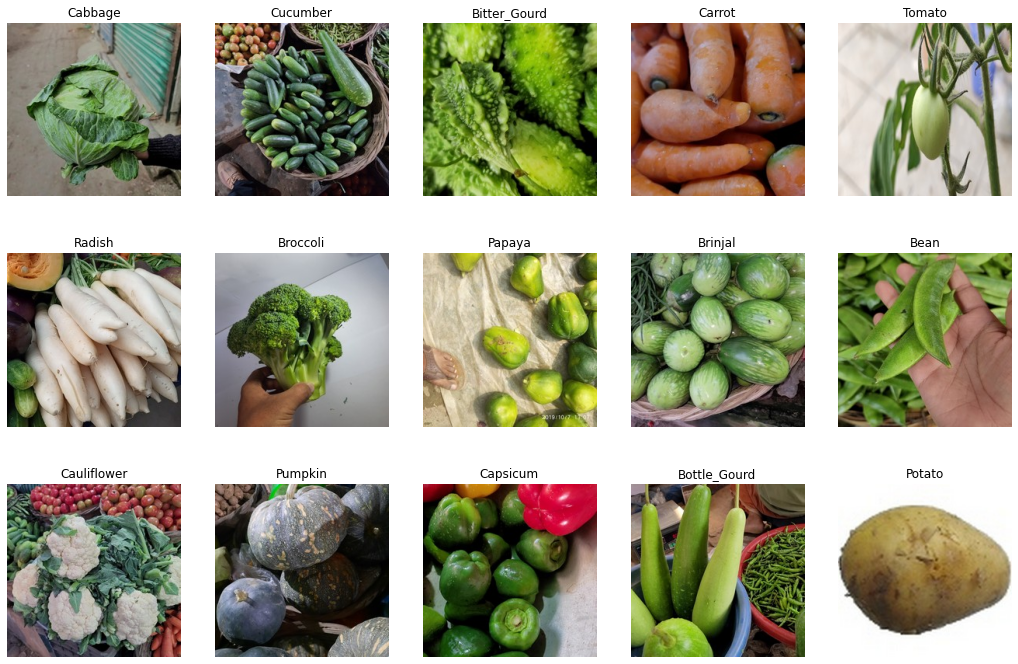

Progress time :  1.6722068786621094


In [7]:
# 데이터 세트 dir
train_dir , test_dir, val_dir = Data_dir + "/train" , Data_dir + "/test" , Data_dir + "/validation"

label_count={}

# 각 label의 랜덤한 사진 출력
start_time = time.time()

labels,imgs = get_img(train_dir)
imgs = show_img(labels,imgs)

end_time = time.time()
print("Progress time : ",end_time-start_time)


In [8]:
print(label_count)

{'Cabbage': 1000, 'Cucumber': 1000, 'Bitter_Gourd': 1000, 'Carrot': 1000, 'Tomato': 1000, 'Radish': 1000, 'Broccoli': 1000, 'Papaya': 1000, 'Brinjal': 1000, 'Bean': 1000, 'Cauliflower': 1000, 'Pumpkin': 1000, 'Capsicum': 1000, 'Bottle_Gourd': 1000, 'Potato': 1000}


In [9]:
randomState = 384   # seed
batchSize = 32
img_height,img_width = 144,144
epochs = 15

In [10]:

# ImageDataGenerator Deprecated

train_data = image_dataset_from_directory(
    train_dir,
    label_mode="int",
    seed = randomState,
    image_size = (img_height,img_width),
    batch_size = batchSize
)
val_data = image_dataset_from_directory(
    val_dir,
    label_mode="int",
    seed = randomState,
    image_size = (img_height,img_width),
    batch_size = batchSize,
    validation_split = 0.5,
    subset = "validation"
)
test_data = image_dataset_from_directory(
    test_dir,
    label_mode="int",
    seed = randomState,
    image_size = (img_height,img_width),
    batch_size = batchSize,
)


Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Using 1500 files for validation.
Found 3000 files belonging to 15 classes.


In [11]:
classes = train_data.class_names
print(classes,end="\n"*4)

print(train_data)


['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']



<BatchDataset element_spec=(TensorSpec(shape=(None, 144, 144, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [12]:
AUTOTUNE = tf.data.AUTOTUNE
# cache = 데이터셋을 메모리에 캐시하여 파일 열기 데이터 읽기 등을 첫 epoch 이후 재사용
# prefetch 데이터 미리 메모리에 load
# AUTOTUNE tf data 런타임이 값을 동적으로 조정
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
print(train_data)


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 144, 144, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [14]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense
from tensorflow.keras.layers import Rescaling


In [15]:
Pre_trained_model = EfficientNetV2B2(
    include_top = False,
    input_shape = (img_height,img_width,3),
    weights = "imagenet",
    pooling = "max"
)
# Pre_trained_model.trainable=False

# Pre_trained_model = Sequential([])
# Pre_trained_model.summary()

model = Sequential([
    Rescaling(1./255,input_shape=(img_height,img_width,3)),
    Pre_trained_model,
    BatchNormalization(),
    Dense(64,activation = "relu"),
    Dense(len(classes),activation = "softmax")
])

35839040/35839040 [==============================] - 3s 0us/step


In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 144, 144, 3)       0         
                                                                 
 efficientnetv2-b2 (Function  (None, 1408)             8769374   
 al)                                                             
                                                                 
 batch_normalization (BatchN  (None, 1408)             5632      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                90176     
                                                                 
 dense_1 (Dense)             (None, 15)                975       
                                                                 
Total params: 8,866,157
Trainable params: 8,781,053
Non-

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])


In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, LearningRateScheduler


In [19]:
# tensorboard 로그
def log_dir():
  return os.path.join(Root_dir,"logs/") + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# LRScheduler용 함수
def scheduler(epoch,lr):
  if epoch <= 5:
    return lr
  else:
    return lr * 0.9

In [20]:
MCP_path=os.path.join(Root_dir,"checkpoint")

In [21]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3)
'''
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    patience=5,
    factor=0.1)
'''
model_checkpoint = ModelCheckpoint(
    MCP_path,
    verbose=1,
    mode="min",
    save_weights_only=True,
    save_best_only=True,
    monitor="val_loss")

tensor_board = TensorBoard(
    log_dir(),
    histogram_freq=1
)

LRScheduler = LearningRateScheduler(
    scheduler
)

In [22]:
history = model.fit(train_data,batch_size=batchSize,epochs=epochs,validation_data=val_data,callbacks=[early_stop,model_checkpoint,tensor_board,LRScheduler])

Epoch 1/15
469/469 [==============================] - ETA: 0s - loss: 2.0427 - accuracy: 0.3855
Epoch 1: val_loss improved from inf to 1.10291, saving model to /content/checkpoint
469/469 [==============================] - 146s 171ms/step - loss: 2.0427 - accuracy: 0.3855 - val_loss: 1.1029 - val_accuracy: 0.6967 - lr: 2.0000e-05
Epoch 2/15
469/469 [==============================] - ETA: 0s - loss: 0.7256 - accuracy: 0.8069
Epoch 2: val_loss improved from 1.10291 to 0.32896, saving model to /content/checkpoint
469/469 [==============================] - 69s 148ms/step - loss: 0.7256 - accuracy: 0.8069 - val_loss: 0.3290 - val_accuracy: 0.9233 - lr: 2.0000e-05
Epoch 3/15
469/469 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.9112
Epoch 3: val_loss improved from 0.32896 to 0.16470, saving model to /content/checkpoint
469/469 [==============================] - 69s 147ms/step - loss: 0.3458 - accuracy: 0.9112 - val_loss: 0.1647 - val_accuracy: 0.9560 - lr: 2.0000e-0

In [23]:
'''
%load_ext tensorboard

%tensorboard --logdir /content/logs
'''

'\n%load_ext tensorboard\n\n%tensorboard --logdir /content/logs\n'

In [24]:

def plot_confusion_matrix(trues,preds):
  cf = confusion_matrix(trues,preds)

  plt.figure(figsize=(10,10))
  plt.imshow(cf)
  plt.title("Confusion Matrix")
  plt.colorbar()
  class_len = np.arange(len(classes))
  plt.xticks(class_len,classes,rotation=25)
  plt.yticks(class_len,classes)

In [25]:
LE = LabelEncoder()
LE.fit(classes)
print(LE.classes_)

['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli' 'Cabbage'
 'Capsicum' 'Carrot' 'Cauliflower' 'Cucumber' 'Papaya' 'Potato' 'Pumpkin'
 'Radish' 'Tomato']


[ 3  0  9 ...  2  5 14]
94/94 [==============================] - 6s 36ms/step
3000 3000


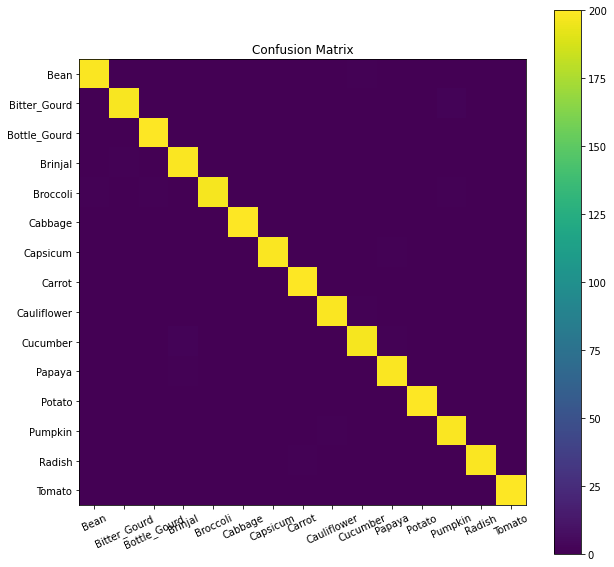

In [26]:

trues = np.concatenate([y for x, y in test_data],axis=0)
print(trues)
preds = np.argmax(model.predict(test_data),axis=1)
print(len(trues),len(preds))

plot_confusion_matrix(trues,preds)


In [27]:
hist = history.history

metrics = list(hist.keys())
linestyles = ["-","-."]

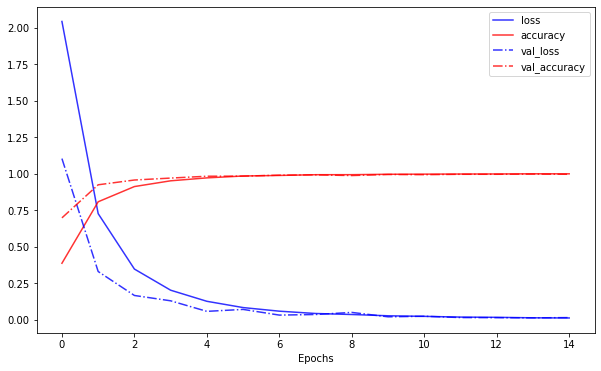

In [28]:


plt.figure(figsize = (10,6))
for i in range(0,4,2):
  idx = i//2
  plt.plot(hist[metrics[i]],c="blue",label=metrics[i],alpha=0.8,linestyle=linestyles[idx])
  plt.plot(hist[metrics[i+1]],c="red",label=metrics[i+1],alpha=0.8,linestyle=linestyles[idx])
plt.xlabel("Epochs")
plt.legend();
plt.show()



In [29]:
model.load_weights(MCP_path)

In [30]:
result = model.evaluate(test_data)
print(result)

94/94 [==============================] - 3s 36ms/step - loss: 0.0166 - accuracy: 0.9953
[0.016559964045882225, 0.9953333139419556]
